In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [172]:
params_dir = os.getcwd()+'/camera_params/' #Calibration -> Parallel image 
print(params_dir)
# Load camera parameters
ret = np.load(params_dir+'ret.npy')
K = np.load(params_dir+'K.npy')
dist = np.load(params_dir+'dist.npy')
focal_length = (K[0,0] + K[1,1])/2

print(K)

d:\GITHUB\final.image/camera_params/
[[726.47630219   0.         466.25758541]
 [  0.         732.0640605  251.997867  ]
 [  0.           0.           1.        ]]


In [173]:
#Declare stereo matching variables
#This section student has to do fine tunes by yourself for max_disp
win_size = 5
min_disparity = -1
max_disparity = 63
num_disparity = max_disparity - min_disparity #Must be divisible by 16.

In [174]:
stereo = cv2.StereoSGBM_create(
    minDisparity = min_disparity, 
    numDisparities = num_disparity,
    blockSize = 20,
    uniquenessRatio = 1,
    speckleWindowSize = 20,
    speckleRange = 5,
    disp12MaxDiff = 2,
    P1 = 8*3*win_size**2,
    P2 = 32*3*win_size**2
    )

In [175]:
def downsampling_image(image, reduction_scale) : # Reduce image resolution Pyr lelel
    for i in range(0, reduction_scale) :
        if len(image.shape) > 2:
            row, col = image.shape[:2]
        else :
            row, col = image.shape
        
        image = cv2.pyrDown(image,dstsize=(col//2,row//2))
    return image

In [176]:
def preprocessimg(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return (img, img_gray)

In [177]:
def sharpening(img):
    kernel = np.array([ [0, 0, 0],
                        [0, 2, 0],
                        [0, 0, 0] ])
    img = cv2.filter2D(img, -1, kernel)
    return (img)


In [178]:
def smoothing(img):
    img = cv2.GaussianBlur(img,(9,9),cv2.BORDER_DEFAULT)
    
    return (img)

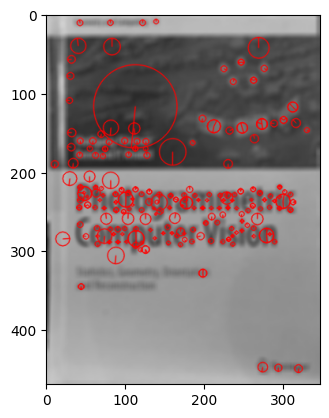

In [179]:
template = cv2.imread("./images/template/Template-3.png")
template = smoothing(template)
template_img,template_gray = preprocessimg(template)
sift = cv2.SIFT_create()
bf = cv2.BFMatcher()
template_kpts , template_desc = sift.detectAndCompute(template_gray,None)
template_gray = cv2.drawKeypoints(template_gray,template_kpts,None,(255,0,0),4)
plt.imshow(template_gray)
# cv2.imshow("AAA",template_gray)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [180]:
left_cap = cv2.VideoCapture('./video/final_exam/Dataset-1/left_output-1.avi')
right_cap = cv2.VideoCapture('./video/final_exam/Dataset-1/right_output-1.avi')

ret ,left_vid = left_cap.read() # You have to read left and right together for syncing the video frame
ret ,right_vid = right_cap.read() 

h, w = left_vid.shape[:2]

#Get the new optimal camera matrix for better undistortion
new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(K, dist, (w,h),1, (w,h))


while left_cap.isOpened() and right_cap.isOpened() :
    ret_left ,left_vid = left_cap.read() # You have to read left and right together for syncing the video frame
    ret_right ,right_vid = right_cap.read() 
    
    if ret_left and ret_right :
        left_vid_gray = cv2.cvtColor(left_vid,cv2.COLOR_BGR2GRAY)
        right_vid_gray = cv2.cvtColor(right_vid,cv2.COLOR_BGR2GRAY)

        #Undistort image
        left_vid_undistorted = cv2.undistort(left_vid_gray, K, dist, None, new_camera_matrix)
        right_vid_undistorted = cv2.undistort(right_vid_gray, K, dist, None, new_camera_matrix)

        #Downsampling each image 1 pyramid level in order to improve computational speed
        left_vid_down = downsampling_image(left_vid_undistorted,1)
        right_vid_down = downsampling_image(right_vid_undistorted,1)


        disparity_map = stereo.compute(left_vid_down, right_vid_down) # Range 0-2 -> 8bits 0-255
        norm_disp = cv2.normalize(disparity_map, None , alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        row, col = norm_disp.shape[:2]
        norm_disp = cv2.pyrUp(norm_disp,dstsize=(col*2, row*2))
        dist_hsv = cv2.applyColorMap(norm_disp,cv2.COLORMAP_JET)

        z = focal_length/disparity_map
        z = cv2.resize(z,(left_vid.shape[1],left_vid.shape[0]))

        sharp_left_vid = sharpening(left_vid)
        sharp_left_vid_gray = cv2.cvtColor(sharp_left_vid,cv2.COLOR_BGR2GRAY)
        print(sharp_left_vid_gray.shape)
        
        query_kpts , query_desc = sift.detectAndCompute(sharp_left_vid_gray,None)
        sharp_left_vid_gray = cv2.drawKeypoints(sharp_left_vid_gray,query_kpts,None,(255,0,0),4)
        matches = bf.knnMatch(template_desc,query_desc,k=2)


        good_matches = list()
        good_matches_list = list()
        for m,n in matches:
            if m.distance <0.8*n.distance :
                good_matches.append(m)
                good_matches_list.append([m])

        min_match_number = 5
        if len(good_matches) > min_match_number:
            src_pts = np.float32([template_kpts[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
            dst_pts = np.float32([query_kpts[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

            H, inlier_masks = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC) # H RANSAC

            h,w = template_img.shape[:2]
            template_box = np.float32([[0, 0] , [0, h-1] , [w-1, h-1] , [w-1, 0]]).reshape(-1,1,2)
            transformed_box = cv2.perspectiveTransform(template_box, H)
           
            cX = ((transformed_box[0,0][0] + transformed_box[2,0][0])/2).astype(int)
            cY = ((transformed_box[0,0][1] + transformed_box[2,0][1])/2).astype(int)
            print(cY,cX)
            if cX <= 864 and cY <=480:
                X = (cX*z[cY,cX])/focal_length 
                Y = (cY*z[cY,cX])/focal_length
                Z = z[cY,cX]

            detected_vid = cv2.polylines(left_vid, [np.int32(transformed_box)], True, (255,0,0), 2, cv2.LINE_AA)
            text = "X:{:.1f} Y:{:.1f} Z:{:.1f}".format(X-0.5,Y-0.5,Z)
            cv2.putText(detected_vid,text,(cX,cY),cv2.FONT_HERSHEY_TRIPLEX,0.5, (0,0,255), 1, cv2.LINE_AA)
            print("Match Found")
            print(len(good_matches),min_match_number)
            cv2.imshow('BF', detected_vid)
            result = cv2.hconcat([sharp_left_vid_gray,detected_vid])
            matched_img = cv2.drawMatchesKnn(template, template_kpts, detected_vid, query_kpts, good_matches_list, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            
            cv2.imshow("math",matched_img)
        else: 
            cv2.imshow('BF', left_vid)
            print("Not Enough match found-")
            print(len(good_matches),min_match_number)

        if cv2.waitKey(33) & 0xFF == ord('q') : # this line control the period between image frame
            break
    else :
        break

left_cap.release()
right_cap.release()
cv2.destroyAllWindows()

C:\Users\natta\AppData\Local\Temp\ipykernel_12244\2862937910.py:37: RuntimeWarning: divide by zero encountered in divide
  z = focal_length/disparity_map


(480, 864)
260 265
Match Found
14 10
(480, 864)
253 260
Match Found
20 10
(480, 864)
255 262
Match Found
17 10
(480, 864)
255 262
Match Found
19 10
(480, 864)
256 263
Match Found
13 10
(480, 864)
254 261
Match Found
18 10
(480, 864)
254 261
Match Found
18 10
(480, 864)
253 261
Match Found
20 10
(480, 864)
255 262
Match Found
20 10
(480, 864)
259 265
Match Found
20 10
(480, 864)
256 262
Match Found
20 10
(480, 864)
253 260
Match Found
22 10
(480, 864)
250 258
Match Found
18 10
(480, 864)
254 261
Match Found
23 10
(480, 864)
254 261
Match Found
23 10
(480, 864)
255 261
Match Found
23 10
(480, 864)
254 261
Match Found
23 10
(480, 864)
254 261
Match Found
22 10
(480, 864)
253 261
Match Found
25 10
(480, 864)
254 261
Match Found
23 10
(480, 864)
254 261
Match Found
23 10
(480, 864)
253 260
Match Found
20 10
(480, 864)
254 262
Match Found
20 10
(480, 864)
254 261
Match Found
25 10
(480, 864)
255 261
Match Found
21 10
(480, 864)
254 261
Match Found
24 10
(480, 864)
255 262
Match Found
22 10
(